In [ ]:
!pip install pytorch-tcn # required

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import numpy as np
import math

In [ ]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)

### Helper Functions

In [ ]:
import math
import numpy as np

# From EEGEyeNet Benchmark paper to maintain the original split ratio and values as per participant ID
def split(ids, train, val, test):
    # proportions of train, val, test
    assert (train+val+test == 1)
    IDs = np.unique(ids)
    num_ids = len(IDs)

    # priority given to the test/val sets
    test_split = math.ceil(test * num_ids)
    val_split = math.ceil(val * num_ids)
    train_split = num_ids - val_split - test_split

    train = np.where(np.isin(ids, IDs[:train_split]))[0]
    val = np.where(np.isin(ids, IDs[train_split:train_split+val_split]))[0]
    test = np.where(np.isin(ids, IDs[train_split+val_split:]))[0]

    return train, val, test

### Connect to Drive

In [ ]:
import os
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define file path
file_path = "/content/drive/MyDrive/datasets/Position_task_with_dots_synchronised_min.npz"

# Step 3: Create the folder if it doesn't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Step 4: Check if file exists, if not, download it
if not os.path.exists(file_path):
    print("File not found. Downloading...")
    !wget -O "/content/drive/MyDrive/datasets/Position_task_with_dots_synchronised_min.npz" "https://osf.io/download/ge87t/"
else:
    print("File already exists at:", file_path)

Mounted at /content/drive
File already exists at: /content/drive/MyDrive/datasets/Position_task_with_dots_synchronised_min.npz


### Dataset Loader

In [ ]:
from torch.utils.data import Dataset
import torch
import numpy as np

# From EEGViT Repo: https://github.com/ruiqiRichard/EEGViT
class EEGEyeNetDataset(Dataset):
        def __init__(self, data_file, transpose=True):
                self.data_file = data_file
                print('loading data...')
                with np.load(self.data_file) as f:  # Load the data array
                        self.trainX = f['EEG']
                        self.trainY = f['labels']

                # Implemented this outlier removal strategy as suggested by this study:
                # Wu, J., Dou, J., & Utoft, S. (2025).
                # Refining Human-Data Interaction: Advanced Techniques for EEGEyeNet Dataset Precision.
                # In International Conference on Human-Computer Interaction (pp. 407-419).
                # Springer, Cham.
                # Filter data where y[:,1] is between 0 and 800 and y[:,2] is between 0 and 600 -- From Outlier removal paper
                valid_indices = (self.trainY[:, 1] >= 0) & (self.trainY[:, 1] <= 800) & \
                                        (self.trainY[:, 2] >= 0) & (self.trainY[:, 2] <= 600)
                self.trainX = self.trainX[valid_indices]
                self.trainY = self.trainY[valid_indices]
                if transpose:
                        self.trainX = np.transpose(self.trainX, (0, 2, 1))[:, np.newaxis, :, :]
                print(self.trainY)

        def __getitem__(self, index):
                # Read a single sample of data from the data array
                X = torch.from_numpy(self.trainX[index]).float()
                y = torch.from_numpy(self.trainY[index,1:3]).float()
                # Return the tensor data
                return (X,y,index)

        def __len__(self):
                # Compute the number of samples in the data array
                return len(self.trainX)

### Model

In [ ]:
import torch
from torch import nn
from pytorch_tcn import TCN
import transformers
from transformers import ViTModel

# Kernal size Modifications motivated by this study:
# Qiu, C., Liang, B., & Key, M. L. (2024, June).
class EEGVIT_TCN_KernalSizeModified(nn.Module):
    def __init__(self):
        super().__init__()

        # TCN layer
        self.tcn = TCN(
            num_inputs=129,
            num_channels=[64, 128, 256],  # for three layers
            kernel_size=3,
            dropout=0.75, # Dropout modifications 70-75% provide the best results
            causal=True,
            use_norm='weight_norm',
            activation='relu',
            kernel_initializer='xavier_uniform'
        )

        # Convolutional layers with batch normalization
        # Kernal Size Modifications
        self.conv1 = torch.nn.Conv2d(1, 256, kernel_size=(1, 16), stride=(1, 16), padding=(0,6)) # Tried Kernelsize & Stride: 1x16, 1x8, 1x4 BEST: 1x8
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = torch.nn.Conv2d(256, 768, kernel_size=(256, 1), stride=(256, 1), padding=(0,0))
        self.bn2 = nn.BatchNorm2d(768)

        self.relu = nn.ReLU()

        # ViT configuration
        model_name = "google/vit-base-patch16-224"
        config = transformers.ViTConfig.from_pretrained(model_name)
        config.update({'num_channels': 768, 'image_size': (1, 32), 'patch_size': (1, 1)}) ## Tried image_size: 1x32, 1x64, 1x128 BEST: 1x64

        model = transformers.ViTForImageClassification.from_pretrained(model_name, config=config, ignore_mismatched_sizes=True)
        model.vit.embeddings.patch_embeddings.projection = torch.nn.Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), padding=(0,0))
        model.classifier = torch.nn.Sequential(
            torch.nn.Linear(768, 1000, bias=True),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(1000, 2, bias=True)
        )
        self.ViT = model

    def forward(self, x):
        x = self.tcn(x.squeeze(1))  # Adjust for time dimension

        # Reshape and apply convolutions and batch normalization
        x = x.view(x.size(0), 1, x.size(1), x.size(2))

        x = self.conv1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.relu(x)

        # Pass through ViT
        x = self.ViT(x).logits
        return x

### Config

In [ ]:
model = EEGVIT_TCN_KernalSizeModified()
model_name = model.__class__.__name__  # Get class name of the model, e.g., "EEGVIT_TCN"
EEGEyeNet = EEGEyeNetDataset(file_path)
batch_size = 64
n_epoch = 15
learning_rate = 1e-4

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- vit.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 768, 1, 1]) in the model instantiated
- vit.embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 33, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import sys
import json

def train(model, optimizer, scheduler = None):
    torch.cuda.empty_cache()
    train_indices, val_indices, test_indices = split(EEGEyeNet.trainY[:,0],0.7,0.15,0.15)  # indices for the training set
    print('create dataloader...')
    criterion = nn.MSELoss()

    train = Subset(EEGEyeNet,indices=train_indices)
    val = Subset(EEGEyeNet,indices=val_indices)
    test = Subset(EEGEyeNet,indices=test_indices)

    train_loader = DataLoader(train, batch_size=batch_size)
    val_loader = DataLoader(val, batch_size=batch_size)
    test_loader = DataLoader(test, batch_size=batch_size)

    if torch.cuda.is_available():
        gpu_id = 0  # Change this to the desired GPU ID if you have multiple GPUs
        torch.cuda.set_device(gpu_id)
        device = torch.device(f"cuda:{gpu_id}")
    else:
        device = torch.device("cpu")
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)  # Wrap the model with DataParallel

    model = model.to(device)
    criterion = criterion.to(device)

    # Initialize lists to store losses
    train_losses = []
    val_losses = []
    test_losses = []
    train_losses_rmse = []
    val_losses_rmse = []
    test_losses_rmse = []

    print('training...')
    # Train the model
    for epoch in range(n_epoch):
        model.train()
        epoch_train_loss = 0.0

        for i, (inputs, targets, index) in tqdm(enumerate(train_loader)):
            # Move the inputs and targets to the GPU (if available)
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Compute the outputs and loss for the current batch
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())

            # Compute the gradients and update the parameters
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        epoch_train_loss /= len(train_loader)
        epoch_train_loss_rmse = np.sqrt(epoch_train_loss) / 2
        train_losses.append(epoch_train_loss)
        train_losses_rmse.append(epoch_train_loss_rmse)
        print(f"Epoch {epoch}, Train Loss: {epoch_train_loss}, RMSE Loss: {epoch_train_loss_rmse}")

        # Evaluate the model on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for inputs, targets, index in val_loader:
                # Move the inputs and targets to the GPU (if available)
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Compute the outputs and loss for the current batch
                outputs = model(inputs)
                # print(outputs)
                loss = criterion(outputs.squeeze(), targets.squeeze())
                val_loss += loss.item()


            val_loss /= len(val_loader)
            val_loss_rmse = np.sqrt(val_loss) / 2
            val_losses.append(val_loss)
            val_losses_rmse.append(val_loss_rmse)
            print(f"Epoch {epoch}, Val Loss: {val_loss}, RMSE Loss: {val_loss_rmse}")

        with torch.no_grad():
            val_loss = 0.0
            for inputs, targets, index in test_loader:
                # Move the inputs and targets to the GPU (if available)
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Compute the outputs and loss for the current batch
                outputs = model(inputs)

                loss = criterion(outputs.squeeze(), targets.squeeze())
                val_loss += loss.item()

            val_loss /= len(test_loader)
            val_loss_rmse = np.sqrt(val_loss) / 2
            test_losses.append(val_loss)
            test_losses_rmse.append(val_loss_rmse)

            print(f"Epoch {epoch}, test Loss: {val_loss}, RMSE Loss: {val_loss_rmse}")

        if scheduler is not None:
            scheduler.step()

    # Combine them into a dictionary
    loss_data = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_losses": test_losses,
        "train_losses_rmse": train_losses_rmse,
        "val_losses_rmse": val_losses_rmse,
        "test_losses_rmse": test_losses_rmse
    }

    # Save to a JSON file
    losses_filename = f"/content/drive/MyDrive/trained_models/losses_{model_name}.json"
    with open(losses_filename, "w") as f:
        json.dump(loss_data, f, indent=4)
    return loss_data

### Train 5 Times & Plot Statistics

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

total_start_time = time.time()
individual_times = []
best_val_losses = []
best_test_losses = []
all_loss_data = []

if torch.cuda.is_available():
    gpu_id = 0  # Change this to the desired GPU ID if you have multiple GPUs
    torch.cuda.set_device(gpu_id)
    device = torch.device(f"cuda:{gpu_id}")
else:
    device = torch.device("cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)  # Wrap the model with DataParallel

for i in range(5):
    print(f"\n====== Training iteration {i + 1} ======")
    start_time = time.time()

    # Reinitialize model, optimizer, scheduler
    model = EEGVIT_TCN_KernalSizeModified().to(device)  # Replace with your actual model class
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

    # Train
    loss_data = train(model, optimizer=optimizer, scheduler=scheduler)

    end_time = time.time()
    iteration_time = end_time - start_time
    individual_times.append(iteration_time)

    # Get best val and test losses
    best_val = min(loss_data["val_losses"])
    best_test = min(loss_data["test_losses"])
    best_val_losses.append(best_val)
    best_test_losses.append(best_test)
    all_loss_data.append(loss_data)

    print(f"Iteration {i + 1} took {iteration_time:.2f} seconds.")
    print(f"  Best validation loss: {best_val:.4f}")
    print(f"  Best test loss: {best_test:.4f}")

    print(f"Train Losses: {loss_data['train_losses']}")
    print(f"Val Losses:   {loss_data['val_losses']}")
    print(f"Test Losses:  {loss_data['test_losses']}")

total_elapsed_time = time.time() - total_start_time
print(f"\nTotal training time for 5 runs: {total_elapsed_time:.2f} seconds.")

# Summary
print("\n====== Summary of best losses per run ======")
for i in range(5):
    print(f"Run {i+1}: Val Loss = {best_val_losses[i]:.4f}, Test Loss = {best_test_losses[i]:.4f}")

# Stats
val_mean = np.mean(best_val_losses)
val_std = np.std(best_val_losses)

print(f"\nAverage best validation loss: {val_mean:.4f}")
print(f"Standard deviation of validation loss: {val_std:.4f}")


====== Training iteration 1 ======


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- vit.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 768, 1, 1]) in the model instantiated
- vit.embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 33, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


create dataloader...
training...


236it [00:28,  8.33it/s]


Epoch 0, Train Loss: 74421.11604541843, RMSE Loss: 136.40116939144843
Epoch 0, Val Loss: 27277.027264030614, RMSE Loss: 82.57879156301364
Epoch 0, test Loss: 27125.54243259804, RMSE Loss: 82.34916883702901


236it [00:28,  8.36it/s]


Epoch 1, Train Loss: 24518.664170087395, RMSE Loss: 78.29218378945531
Epoch 1, Val Loss: 22729.079400510203, RMSE Loss: 75.38083211352573
Epoch 1, test Loss: 21783.95534620098, RMSE Loss: 73.79694327375792


236it [00:28,  8.35it/s]


Epoch 2, Train Loss: 21205.88961119571, RMSE Loss: 72.81121069450039
Epoch 2, Val Loss: 18753.503786670917, RMSE Loss: 68.47171639931139
Epoch 2, test Loss: 16815.839116115196, RMSE Loss: 64.83795014517963


236it [00:28,  8.28it/s]


Epoch 3, Train Loss: 16635.06984904661, RMSE Loss: 64.48850643534593
Epoch 3, Val Loss: 16130.334303252552, RMSE Loss: 63.502626526885784
Epoch 3, test Loss: 12947.975471047794, RMSE Loss: 56.89458557509624


236it [00:28,  8.35it/s]


Epoch 4, Train Loss: 14784.898867849577, RMSE Loss: 60.79658474752011
Epoch 4, Val Loss: 16660.517159598214, RMSE Loss: 64.5378128688876
Epoch 4, test Loss: 12977.718692555147, RMSE Loss: 56.959895304843975


236it [00:28,  8.35it/s]


Epoch 5, Train Loss: 14067.57862776417, RMSE Loss: 59.30341184907528
Epoch 5, Val Loss: 16219.229073660714, RMSE Loss: 63.67736857326297
Epoch 5, test Loss: 12388.108992034313, RMSE Loss: 55.65094112419464


236it [00:28,  8.35it/s]


Epoch 6, Train Loss: 13137.667300466765, RMSE Loss: 57.30983183640213
Epoch 6, Val Loss: 15801.54282924107, RMSE Loss: 62.85209389758043
Epoch 6, test Loss: 11756.236213235294, RMSE Loss: 54.21308931714576


236it [00:28,  8.31it/s]


Epoch 7, Train Loss: 12795.147367833024, RMSE Loss: 56.557818574961466
Epoch 7, Val Loss: 15799.173867984693, RMSE Loss: 62.84738234004797
Epoch 7, test Loss: 11694.322897518383, RMSE Loss: 54.07014633214521


236it [00:28,  8.29it/s]


Epoch 8, Train Loss: 12598.596965207891, RMSE Loss: 56.12173590777439
Epoch 8, Val Loss: 15780.109952965562, RMSE Loss: 62.8094538126339
Epoch 8, test Loss: 11669.469649969362, RMSE Loss: 54.01265974280789


236it [00:28,  8.27it/s]


Epoch 9, Train Loss: 12427.783995547537, RMSE Loss: 55.73998563766306
Epoch 9, Val Loss: 15767.174924266581, RMSE Loss: 62.78370593606788
Epoch 9, test Loss: 11584.379375382965, RMSE Loss: 53.815377392021894


236it [00:28,  8.36it/s]


Epoch 10, Train Loss: 12288.467732057734, RMSE Loss: 55.426680696343645
Epoch 10, Val Loss: 15671.299246651786, RMSE Loss: 62.592529998898
Epoch 10, test Loss: 11486.621074601715, RMSE Loss: 53.58782761645063


236it [00:28,  8.33it/s]


Epoch 11, Train Loss: 12133.532634153204, RMSE Loss: 55.07615780479155
Epoch 11, Val Loss: 15620.952845982143, RMSE Loss: 62.49190516775381
Epoch 11, test Loss: 11429.946920955883, RMSE Loss: 53.45546492398107


236it [00:28,  8.36it/s]


Epoch 12, Train Loss: 12056.567076602225, RMSE Loss: 54.90120007022211
Epoch 12, Val Loss: 14795.44407684949, RMSE Loss: 60.81826221795862
Epoch 12, test Loss: 10601.501455269608, RMSE Loss: 51.4817964315291


236it [00:28,  8.38it/s]


Epoch 13, Train Loss: 11869.18277339612, RMSE Loss: 54.472889526341724
Epoch 13, Val Loss: 14710.663763552297, RMSE Loss: 60.643762588481216
Epoch 13, test Loss: 10493.377776501226, RMSE Loss: 51.21859471056685


236it [00:28,  8.37it/s]


Epoch 14, Train Loss: 11830.069675251589, RMSE Loss: 54.383061874198454
Epoch 14, Val Loss: 14717.220513791453, RMSE Loss: 60.657275972861356
Epoch 14, test Loss: 10488.81201171875, RMSE Loss: 51.20745065837283
Iteration 1 took 495.14 seconds.
  Best validation loss: 14710.6638
  Best test loss: 10488.8120
Train Losses: [74421.11604541843, 24518.664170087395, 21205.88961119571, 16635.06984904661, 14784.898867849577, 14067.57862776417, 13137.667300466765, 12795.147367833024, 12598.596965207891, 12427.783995547537, 12288.467732057734, 12133.532634153204, 12056.567076602225, 11869.18277339612, 11830.069675251589]
Val Losses:   [27277.027264030614, 22729.079400510203, 18753.503786670917, 16130.334303252552, 16660.517159598214, 16219.229073660714, 15801.54282924107, 15799.173867984693, 15780.109952965562, 15767.174924266581, 15671.299246651786, 15620.952845982143, 14795.44407684949, 14710.663763552297, 14717.220513791453]
Test Losses:  [27125.54243259804, 21783.95534620098, 16815.8391161151

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- vit.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 768, 1, 1]) in the model instantiated
- vit.embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 33, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


create dataloader...
training...


236it [00:28,  8.37it/s]


Epoch 0, Train Loss: 74196.90316306938, RMSE Loss: 136.19554247759854
Epoch 0, Val Loss: 26556.891382334183, RMSE Loss: 81.48142638407569
Epoch 0, test Loss: 26084.57456341912, RMSE Loss: 80.75359831521305


236it [00:28,  8.30it/s]


Epoch 1, Train Loss: 24667.37995729608, RMSE Loss: 78.529261994011
Epoch 1, Val Loss: 23054.554528061224, RMSE Loss: 75.91863165268
Epoch 1, test Loss: 21893.774777879902, RMSE Loss: 73.98272564909985


236it [00:28,  8.37it/s]


Epoch 2, Train Loss: 20753.99254750397, RMSE Loss: 72.03123028850744
Epoch 2, Val Loss: 18493.626355229593, RMSE Loss: 67.99563654240909
Epoch 2, test Loss: 16272.186982996323, RMSE Loss: 63.781241331202395


236it [00:28,  8.37it/s]


Epoch 3, Train Loss: 16264.941567631091, RMSE Loss: 63.7670400121236
Epoch 3, Val Loss: 16765.075374681124, RMSE Loss: 64.74000960511421
Epoch 3, test Loss: 13638.901865042892, RMSE Loss: 58.3928545822237


236it [00:28,  8.30it/s]


Epoch 4, Train Loss: 14693.987863314354, RMSE Loss: 60.60938018020469
Epoch 4, Val Loss: 16623.07912149235, RMSE Loss: 64.46526025987242
Epoch 4, test Loss: 12956.553232230392, RMSE Loss: 56.91342818753407


236it [00:28,  8.38it/s]


Epoch 5, Train Loss: 14001.08385816671, RMSE Loss: 59.16308785502729
Epoch 5, Val Loss: 16206.95424107143, RMSE Loss: 63.65326826069387
Epoch 5, test Loss: 12302.981885723038, RMSE Loss: 55.45940381423839


236it [00:28,  8.37it/s]


Epoch 6, Train Loss: 13056.110136387711, RMSE Loss: 57.13166839938186
Epoch 6, Val Loss: 15101.162149234693, RMSE Loss: 61.44339295081834
Epoch 6, test Loss: 11230.185566023285, RMSE Loss: 52.9862849377631


236it [00:28,  8.39it/s]


Epoch 7, Train Loss: 12678.085844395524, RMSE Loss: 56.29850318701982
Epoch 7, Val Loss: 15088.126514668367, RMSE Loss: 61.41686762337438
Epoch 7, test Loss: 11140.870107613358, RMSE Loss: 52.77516013147984


236it [00:28,  8.29it/s]


Epoch 8, Train Loss: 12487.364137811175, RMSE Loss: 55.87343764663844
Epoch 8, Val Loss: 15071.433015784438, RMSE Loss: 61.38288241803336
Epoch 8, test Loss: 11056.373573452818, RMSE Loss: 52.57464591762083


236it [00:28,  8.36it/s]


Epoch 9, Train Loss: 12300.854725983183, RMSE Loss: 55.45460919973917
Epoch 9, Val Loss: 15011.827397560586, RMSE Loss: 61.261381386564786
Epoch 9, test Loss: 10960.93758616728, RMSE Loss: 52.347248223204815


236it [00:28,  8.34it/s]


Epoch 10, Train Loss: 12136.712371308924, RMSE Loss: 55.08337401455389
Epoch 10, Val Loss: 15020.343580596302, RMSE Loss: 61.27875565927457
Epoch 10, test Loss: 10916.979501761642, RMSE Loss: 52.242175255634315


236it [00:28,  8.27it/s]


Epoch 11, Train Loss: 12007.426412291446, RMSE Loss: 54.78920151884732
Epoch 11, Val Loss: 14958.650819116709, RMSE Loss: 61.15278166019251
Epoch 11, test Loss: 10855.41077856924, RMSE Loss: 52.094651305506495


236it [00:28,  8.33it/s]


Epoch 12, Train Loss: 11889.778895491261, RMSE Loss: 54.52013136331217
Epoch 12, Val Loss: 14588.099489795919, RMSE Loss: 60.39060251768465
Epoch 12, test Loss: 10383.362764246323, RMSE Loss: 50.94939343173362


236it [00:28,  8.34it/s]


Epoch 13, Train Loss: 11742.633561473782, RMSE Loss: 54.181716384482
Epoch 13, Val Loss: 14536.225595902424, RMSE Loss: 60.28313527824848
Epoch 13, test Loss: 10320.401903339462, RMSE Loss: 50.79468944520544


236it [00:28,  8.35it/s]


Epoch 14, Train Loss: 11746.779574119439, RMSE Loss: 54.19128060426197
Epoch 14, Val Loss: 14531.18031529018, RMSE Loss: 60.27267273667682
Epoch 14, test Loss: 10311.283222273285, RMSE Loss: 50.77224444091792
Iteration 2 took 494.86 seconds.
  Best validation loss: 14531.1803
  Best test loss: 10311.2832
Train Losses: [74196.90316306938, 24667.37995729608, 20753.99254750397, 16264.941567631091, 14693.987863314354, 14001.08385816671, 13056.110136387711, 12678.085844395524, 12487.364137811175, 12300.854725983183, 12136.712371308924, 12007.426412291446, 11889.778895491261, 11742.633561473782, 11746.779574119439]
Val Losses:   [26556.891382334183, 23054.554528061224, 18493.626355229593, 16765.075374681124, 16623.07912149235, 16206.95424107143, 15101.162149234693, 15088.126514668367, 15071.433015784438, 15011.827397560586, 15020.343580596302, 14958.650819116709, 14588.099489795919, 14536.225595902424, 14531.18031529018]
Test Losses:  [26084.57456341912, 21893.774777879902, 16272.18698299632

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- vit.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 768, 1, 1]) in the model instantiated
- vit.embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 33, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


create dataloader...
training...


236it [00:28,  8.35it/s]


Epoch 0, Train Loss: 74647.09383275954, RMSE Loss: 136.608101729692
Epoch 0, Val Loss: 26838.489078443876, RMSE Loss: 81.91228399703532
Epoch 0, test Loss: 26695.536228553923, RMSE Loss: 81.69384344697268


236it [00:28,  8.37it/s]


Epoch 1, Train Loss: 24592.240424721927, RMSE Loss: 78.40956642005159
Epoch 1, Val Loss: 22698.458506058672, RMSE Loss: 75.33003800951296
Epoch 1, test Loss: 21778.20477175245, RMSE Loss: 73.7872020945239


236it [00:28,  8.32it/s]


Epoch 2, Train Loss: 20053.682211665782, RMSE Loss: 70.80551216477744
Epoch 2, Val Loss: 17817.220204878828, RMSE Loss: 66.740580243355
Epoch 2, test Loss: 15584.739315257353, RMSE Loss: 62.419426694053655


236it [00:28,  8.36it/s]


Epoch 3, Train Loss: 16049.138328422934, RMSE Loss: 63.34259690055132
Epoch 3, Val Loss: 16218.024433992347, RMSE Loss: 63.675003796608344
Epoch 3, test Loss: 13348.47087545956, RMSE Loss: 57.7677913621846


236it [00:28,  8.34it/s]


Epoch 4, Train Loss: 14682.224179025423, RMSE Loss: 60.58511405251587
Epoch 4, Val Loss: 16511.499322385203, RMSE Loss: 64.24853952111519
Epoch 4, test Loss: 13038.041053921568, RMSE Loss: 57.0921208528847


236it [00:28,  8.35it/s]


Epoch 5, Train Loss: 14079.702845686574, RMSE Loss: 59.328961826595645
Epoch 5, Val Loss: 16477.87591677296, RMSE Loss: 64.18308951112621
Epoch 5, test Loss: 13205.21231617647, RMSE Loss: 57.45696719323182


236it [00:28,  8.35it/s]


Epoch 6, Train Loss: 13035.776598914195, RMSE Loss: 57.08716274022163
Epoch 6, Val Loss: 15175.26185825893, RMSE Loss: 61.59395639642523
Epoch 6, test Loss: 11600.726639093138, RMSE Loss: 53.85333471358375


236it [00:28,  8.38it/s]


Epoch 7, Train Loss: 12648.921115681276, RMSE Loss: 56.233711231967604
Epoch 7, Val Loss: 15102.625119579081, RMSE Loss: 61.44636913516347
Epoch 7, test Loss: 11427.914253982843, RMSE Loss: 53.45071153404518


236it [00:28,  8.38it/s]


Epoch 8, Train Loss: 12450.567546262579, RMSE Loss: 55.79105561436927
Epoch 8, Val Loss: 15108.76048309949, RMSE Loss: 61.45884900301073
Epoch 8, test Loss: 11377.597598805147, RMSE Loss: 53.33291103719435


236it [00:28,  8.39it/s]


Epoch 9, Train Loss: 12283.61900200278, RMSE Loss: 55.41574460837547
Epoch 9, Val Loss: 15114.157007334185, RMSE Loss: 61.469823912498285
Epoch 9, test Loss: 11328.402362898285, RMSE Loss: 53.21748388194026


236it [00:28,  8.30it/s]


Epoch 10, Train Loss: 12173.882822844942, RMSE Loss: 55.1676599622572
Epoch 10, Val Loss: 15153.808832908164, RMSE Loss: 61.550403802306946
Epoch 10, test Loss: 11299.096449908087, RMSE Loss: 53.14860405012555


236it [00:28,  8.38it/s]


Epoch 11, Train Loss: 11967.670219809323, RMSE Loss: 54.69842369714442
Epoch 11, Val Loss: 15130.191466039541, RMSE Loss: 61.50242163126494
Epoch 11, test Loss: 11208.27880859375, RMSE Loss: 52.934579455668086


236it [00:28,  8.38it/s]


Epoch 12, Train Loss: 11867.994533732786, RMSE Loss: 54.47016278140902
Epoch 12, Val Loss: 14646.419314014669, RMSE Loss: 60.51119589384817
Epoch 12, test Loss: 10758.883597579657, RMSE Loss: 51.86251921566204


236it [00:28,  8.38it/s]


Epoch 13, Train Loss: 11658.119461318194, RMSE Loss: 53.98638592580122
Epoch 13, Val Loss: 14595.537278778698, RMSE Loss: 60.405995726373675
Epoch 13, test Loss: 10703.427207797182, RMSE Loss: 51.72868451786973


236it [00:28,  8.36it/s]


Epoch 14, Train Loss: 11677.621621342028, RMSE Loss: 54.03152233035367
Epoch 14, Val Loss: 14581.362224968112, RMSE Loss: 60.376655722572345
Epoch 14, test Loss: 10691.208831188726, RMSE Loss: 51.69915093884213
Iteration 3 took 493.78 seconds.
  Best validation loss: 14581.3622
  Best test loss: 10691.2088
Train Losses: [74647.09383275954, 24592.240424721927, 20053.682211665782, 16049.138328422934, 14682.224179025423, 14079.702845686574, 13035.776598914195, 12648.921115681276, 12450.567546262579, 12283.61900200278, 12173.882822844942, 11967.670219809323, 11867.994533732786, 11658.119461318194, 11677.621621342028]
Val Losses:   [26838.489078443876, 22698.458506058672, 17817.220204878828, 16218.024433992347, 16511.499322385203, 16477.87591677296, 15175.26185825893, 15102.625119579081, 15108.76048309949, 15114.157007334185, 15153.808832908164, 15130.191466039541, 14646.419314014669, 14595.537278778698, 14581.362224968112]
Test Losses:  [26695.536228553923, 21778.20477175245, 15584.7393152

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- vit.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 768, 1, 1]) in the model instantiated
- vit.embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 33, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


create dataloader...
training...


236it [00:28,  8.35it/s]


Epoch 0, Train Loss: 75233.90673828125, RMSE Loss: 137.1439998124975
Epoch 0, Val Loss: 27425.89596619898, RMSE Loss: 82.80382836288274
Epoch 0, test Loss: 27187.906403186276, RMSE Loss: 82.44377842382389


236it [00:28,  8.37it/s]


Epoch 1, Train Loss: 24748.977133540782, RMSE Loss: 78.65903815446255
Epoch 1, Val Loss: 22770.893933354593, RMSE Loss: 75.45013905446861
Epoch 1, test Loss: 21978.611787683825, RMSE Loss: 74.12592628035725


236it [00:28,  8.36it/s]


Epoch 2, Train Loss: 21147.762881521452, RMSE Loss: 72.71135207366429
Epoch 2, Val Loss: 18422.389508928572, RMSE Loss: 67.86455169845405
Epoch 2, test Loss: 16669.471105238972, RMSE Loss: 64.5551529802985


236it [00:28,  8.39it/s]


Epoch 3, Train Loss: 16633.35032110699, RMSE Loss: 64.48517333679695
Epoch 3, Val Loss: 16707.425223214286, RMSE Loss: 64.62860284582649
Epoch 3, test Loss: 14339.210860906862, RMSE Loss: 59.873222021423864


236it [00:28,  8.39it/s]


Epoch 4, Train Loss: 14927.587207858845, RMSE Loss: 61.08925275336662
Epoch 4, Val Loss: 16059.88450653699, RMSE Loss: 63.36379981215021
Epoch 4, test Loss: 13213.662760416666, RMSE Loss: 57.47534854269408


236it [00:28,  8.39it/s]


Epoch 5, Train Loss: 14258.875035172801, RMSE Loss: 59.7052657543135
Epoch 5, Val Loss: 17296.268315529338, RMSE Loss: 65.75763893938357
Epoch 5, test Loss: 14398.440889246323, RMSE Loss: 59.99675176467123


236it [00:28,  8.36it/s]


Epoch 6, Train Loss: 13506.064684851695, RMSE Loss: 58.10779785203466
Epoch 6, Val Loss: 15411.146006058674, RMSE Loss: 62.07081843760938
Epoch 6, test Loss: 11891.942976409313, RMSE Loss: 54.52509279315651


236it [00:28,  8.36it/s]


Epoch 7, Train Loss: 13079.149378889699, RMSE Loss: 57.18205439403541
Epoch 7, Val Loss: 15358.21607940051, RMSE Loss: 61.964134947969114
Epoch 7, test Loss: 11698.070274203432, RMSE Loss: 54.07880886771507


236it [00:28,  8.33it/s]


Epoch 8, Train Loss: 12948.517276052702, RMSE Loss: 56.895775932956354
Epoch 8, Val Loss: 15390.956592793367, RMSE Loss: 62.03014709154204
Epoch 8, test Loss: 11652.234279258579, RMSE Loss: 53.97275766360882


236it [00:28,  8.36it/s]


Epoch 9, Train Loss: 12752.574423579847, RMSE Loss: 56.463648535097
Epoch 9, Val Loss: 15326.96579041773, RMSE Loss: 61.90106176475838
Epoch 9, test Loss: 11545.090829886642, RMSE Loss: 53.72404217360846


236it [00:28,  8.30it/s]


Epoch 10, Train Loss: 12648.336825096001, RMSE Loss: 56.232412417341656
Epoch 10, Val Loss: 15249.473014987245, RMSE Loss: 61.74437831695134
Epoch 10, test Loss: 11432.299996170343, RMSE Loss: 53.460967060488024


236it [00:28,  8.35it/s]


Epoch 11, Train Loss: 12476.405246540651, RMSE Loss: 55.848915044387056
Epoch 11, Val Loss: 15291.212870695153, RMSE Loss: 61.828821901066405
Epoch 11, test Loss: 11435.355420879288, RMSE Loss: 53.468110638209595


236it [00:28,  8.33it/s]


Epoch 12, Train Loss: 12483.059284792109, RMSE Loss: 55.86380600351203
Epoch 12, Val Loss: 14698.867346938776, RMSE Loss: 60.61944272867158
Epoch 12, test Loss: 10766.297353707108, RMSE Loss: 51.88038491016405


236it [00:28,  8.35it/s]


Epoch 13, Train Loss: 12313.167639780853, RMSE Loss: 55.482356744691494
Epoch 13, Val Loss: 14611.516780931122, RMSE Loss: 60.43905356003501
Epoch 13, test Loss: 10705.779622395834, RMSE Loss: 51.734368707842165


236it [00:28,  8.39it/s]


Epoch 14, Train Loss: 12279.34865764036, RMSE Loss: 55.40611125507808
Epoch 14, Val Loss: 14589.575145487883, RMSE Loss: 60.393656838876474
Epoch 14, test Loss: 10695.812567018995, RMSE Loss: 51.71028081295584
Iteration 4 took 493.97 seconds.
  Best validation loss: 14589.5751
  Best test loss: 10695.8126
Train Losses: [75233.90673828125, 24748.977133540782, 21147.762881521452, 16633.35032110699, 14927.587207858845, 14258.875035172801, 13506.064684851695, 13079.149378889699, 12948.517276052702, 12752.574423579847, 12648.336825096001, 12476.405246540651, 12483.059284792109, 12313.167639780853, 12279.34865764036]
Val Losses:   [27425.89596619898, 22770.893933354593, 18422.389508928572, 16707.425223214286, 16059.88450653699, 17296.268315529338, 15411.146006058674, 15358.21607940051, 15390.956592793367, 15326.96579041773, 15249.473014987245, 15291.212870695153, 14698.867346938776, 14611.516780931122, 14589.575145487883]
Test Losses:  [27187.906403186276, 21978.611787683825, 16669.471105238

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- vit.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 768, 1, 1]) in the model instantiated
- vit.embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 33, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


create dataloader...
training...


236it [00:28,  8.39it/s]


Epoch 0, Train Loss: 74299.87572828389, RMSE Loss: 136.2900177271651
Epoch 0, Val Loss: 27439.02104591837, RMSE Loss: 82.82363950877547
Epoch 0, test Loss: 27170.69366574755, RMSE Loss: 82.41767660178785


236it [00:28,  8.39it/s]


Epoch 1, Train Loss: 24735.807344081037, RMSE Loss: 78.63810676777678
Epoch 1, Val Loss: 23374.015784438776, RMSE Loss: 76.44281487562905
Epoch 1, test Loss: 22500.117647058825, RMSE Loss: 75.00019607817507


236it [00:28,  8.40it/s]


Epoch 2, Train Loss: 21291.824562202066, RMSE Loss: 72.95859195838771
Epoch 2, Val Loss: 19192.85307716837, RMSE Loss: 69.26913648438308
Epoch 2, test Loss: 17447.072208180147, RMSE Loss: 66.04368290794386


236it [00:28,  8.36it/s]


Epoch 3, Train Loss: 16579.16887082892, RMSE Loss: 64.38006071531177
Epoch 3, Val Loss: 16426.908601721938, RMSE Loss: 64.08375106398255
Epoch 3, test Loss: 13242.642041973038, RMSE Loss: 57.53833948328071


236it [00:28,  8.39it/s]


Epoch 4, Train Loss: 14980.068251787607, RMSE Loss: 61.19654453436813
Epoch 4, Val Loss: 15909.294304049745, RMSE Loss: 63.06602552890452
Epoch 4, test Loss: 12533.471354166666, RMSE Loss: 55.97649362492855


236it [00:28,  8.38it/s]


Epoch 5, Train Loss: 14267.109422586733, RMSE Loss: 59.72250292516786
Epoch 5, Val Loss: 15896.78822544643, RMSE Loss: 63.041232985734084
Epoch 5, test Loss: 12148.704752604166, RMSE Loss: 55.11058145357425


236it [00:28,  8.38it/s]


Epoch 6, Train Loss: 13240.037181789592, RMSE Loss: 57.53268023869041
Epoch 6, Val Loss: 15364.033362563776, RMSE Loss: 61.97586901884429
Epoch 6, test Loss: 11511.491680070465, RMSE Loss: 53.6458099017772


236it [00:28,  8.37it/s]


Epoch 7, Train Loss: 13019.360055697167, RMSE Loss: 57.051205192566194
Epoch 7, Val Loss: 15305.673628826531, RMSE Loss: 61.858050463998886
Epoch 7, test Loss: 11389.771063112745, RMSE Loss: 53.361435192263954


236it [00:28,  8.42it/s]


Epoch 8, Train Loss: 12852.722921080509, RMSE Loss: 56.68492507069342
Epoch 8, Val Loss: 15314.262356505102, RMSE Loss: 61.87540374919808
Epoch 8, test Loss: 11309.314931832108, RMSE Loss: 53.17263142781282


236it [00:28,  8.40it/s]


Epoch 9, Train Loss: 12674.895410570047, RMSE Loss: 56.291418996526566
Epoch 9, Val Loss: 15313.273078762755, RMSE Loss: 61.873405189068826
Epoch 9, test Loss: 11248.246380974264, RMSE Loss: 53.0288751082235


236it [00:28,  8.22it/s]


Epoch 10, Train Loss: 12542.195101463189, RMSE Loss: 55.99597106369169
Epoch 10, Val Loss: 15293.435247927297, RMSE Loss: 61.833314741988595
Epoch 10, test Loss: 11211.836722579657, RMSE Loss: 52.94298046620453


236it [00:28,  8.39it/s]


Epoch 11, Train Loss: 12389.887674622616, RMSE Loss: 55.65493615714292
Epoch 11, Val Loss: 15261.204480229591, RMSE Loss: 61.76812381849879
Epoch 11, test Loss: 11111.791829427084, RMSE Loss: 52.706242109988935


236it [00:28,  8.24it/s]


Epoch 12, Train Loss: 12394.310594461733, RMSE Loss: 55.664869070316094
Epoch 12, Val Loss: 14743.498046875, RMSE Loss: 60.711403473472345
Epoch 12, test Loss: 10616.629863664215, RMSE Loss: 51.518515758085016


236it [00:28,  8.39it/s]


Epoch 13, Train Loss: 12240.743534411415, RMSE Loss: 55.318946877203416
Epoch 13, Val Loss: 14668.658860809948, RMSE Loss: 60.557119442741715
Epoch 13, test Loss: 10569.437490425858, RMSE Loss: 51.40388480072751


236it [00:28,  8.38it/s]


Epoch 14, Train Loss: 12161.386683577199, RMSE Loss: 55.139338687495155
Epoch 14, Val Loss: 14650.823909837372, RMSE Loss: 60.520293930708426
Epoch 14, test Loss: 10557.020814185049, RMSE Loss: 51.373682012741334
Iteration 5 took 493.29 seconds.
  Best validation loss: 14650.8239
  Best test loss: 10557.0208
Train Losses: [74299.87572828389, 24735.807344081037, 21291.824562202066, 16579.16887082892, 14980.068251787607, 14267.109422586733, 13240.037181789592, 13019.360055697167, 12852.722921080509, 12674.895410570047, 12542.195101463189, 12389.887674622616, 12394.310594461733, 12240.743534411415, 12161.386683577199]
Val Losses:   [27439.02104591837, 23374.015784438776, 19192.85307716837, 16426.908601721938, 15909.294304049745, 15896.78822544643, 15364.033362563776, 15305.673628826531, 15314.262356505102, 15313.273078762755, 15293.435247927297, 15261.204480229591, 14743.498046875, 14668.658860809948, 14650.823909837372]
Test Losses:  [27170.69366574755, 22500.117647058825, 17447.07220818

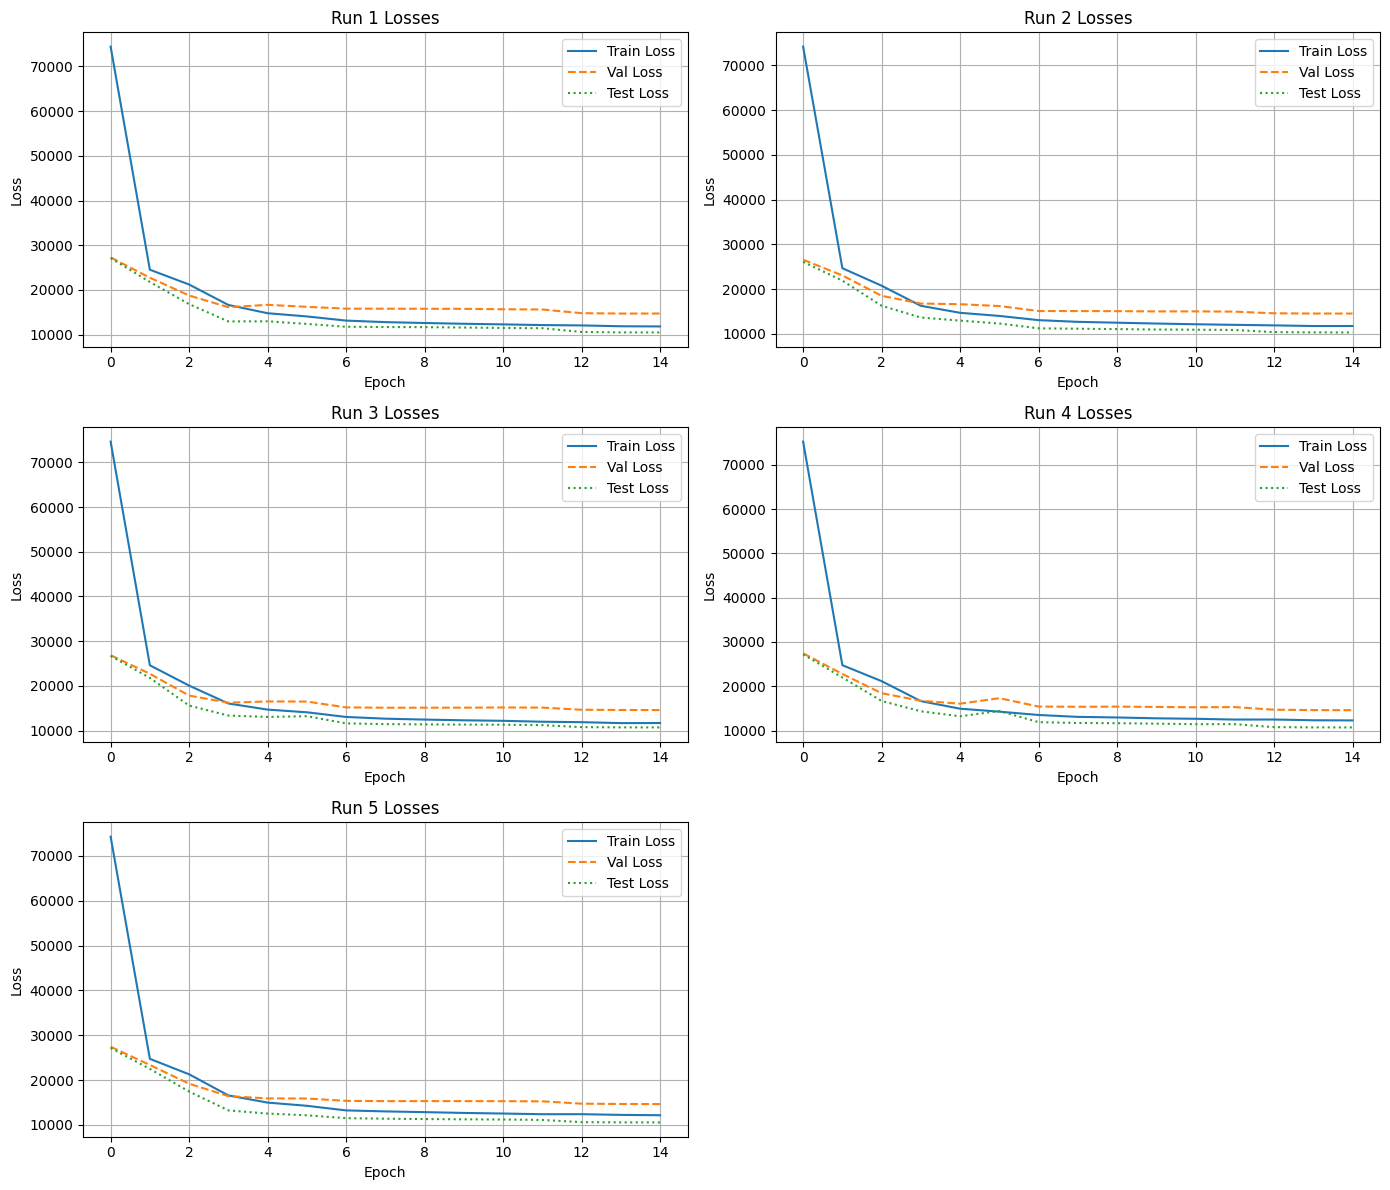

In [ ]:
import matplotlib.pyplot as plt

# Create 5 subplots (one for each run)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
axes = axes.flatten()  # Flatten to easily iterate
num_runs = len(all_loss_data)

for i, loss_data in enumerate(all_loss_data):
    ax = axes[i]
    ax.plot(loss_data["train_losses"], label="Train Loss", linestyle='-')
    ax.plot(loss_data["val_losses"], label="Val Loss", linestyle='--')
    ax.plot(loss_data["test_losses"], label="Test Loss", linestyle=':')
    ax.set_title(f"Run {i+1} Losses")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)

# Hide any unused subplots if less than 6
for j in range(num_runs, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
# Save the final model
# torch.save(model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(), f"/content/drive/MyDrive/trained_models/{model_name}.pt")
# print("Model saved as EEGViT_TCN_Modified_Kernal_Dropout.pt")

Model saved as EEGViT_TCN_Modified_Kernal_Dropout.pt
